In [17]:
%autoreload 2

In [21]:
import logging 
logging.basicConfig()
logging.getLogger("sparklink").setLevel(logging.WARNING)

In [22]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf=SparkConf()
conf.set('spark.driver.memory', '8g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [27]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



In [28]:
blocking_rules = [
    'l.first_name = r.first_name  and  l.surname = r.surname',
    'l.first_name = r.first_name  and  l.surname = r.surname',
    
    'l.first_name = r.first_name  and  l.dob = r.dob',
    'l.first_name = r.first_name  and  l.city = r.city',
    'l.dob = r.dob  and  l.city = r.city'
]

In [29]:
from sparklink.blocking import block_using_rules
df_comparison = block_using_rules(df, blocking_rules, spark=spark)
df_comparison.show(5)
# df_comparison = cartestian_block(df, df.columns, spark=spark)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|             email_l|             email_r|group_l|group_r|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+
|          6|         11|      Watson|      Watson|    Noah |    Noah |2008-03-23|2008-01-21|  null| Bolno|matthew78@ballard...|matthea78@bwllar-...|      1|      1|
|         38|         41|     Olivia |     Olivia |  Andrews|  Andrews|2009-01-23|2009-01-23|  null|London|hesterkurt@taylor...|hesterkurt@taylor...|      9|      9|
|         40|         42|     Olivia |     Olivia |  Andrews|  Andrews|2009-03-24|2009-01-23|London|London|hesterkurt@taylor...|hesterkuot@taylrr...|      9|      9|
|   

In [116]:
from sparklink.gammas import add_gammas

gamma_settings = {
    "first_name": {
        "levels": 3,
    },
    "surname": {
        "levels": 3
    },
    "dob": {
        "levels": 2
    },
    "city": {
        "levels": 2
    },
    "email": {
        "levels": 2
    }
}



df_gammas = add_gammas(df_comparison, gamma_settings, spark, include_orig_cols = True)
df_gammas.show(5)

+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+-------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|city_l|city_r|             email_l|             email_r|gamma_0|gamma_1|gamma_2|gamma_3|gamma_4|
+-----------+-----------+------------+------------+---------+---------+----------+----------+------+------+--------------------+--------------------+-------+-------+-------+-------+-------+
|          6|         11|      Watson|      Watson|    Noah |    Noah |2008-03-23|2008-01-21|  null| Bolno|matthew78@ballard...|matthea78@bwllar-...|      2|      2|      0|     -1|      0|
|         38|         41|     Olivia |     Olivia |  Andrews|  Andrews|2009-01-23|2009-01-23|  null|London|hesterkurt@taylor...|hesterkurt@taylor...|      2|      2|      1|     -1|      1|
|         40|         42|     Olivia |     Olivia 

In [117]:
from sparklink.params import Params 
params = Params(gamma_settings, starting_lambda=0.5)

In [118]:
from sparklink.expectation_step import run_expectation_step
df_e= run_expectation_step(df_gammas, spark, params, compute_ll=True)

In [174]:
df_e = iterate(df_gammas, spark, params, num_iterations=2, compute_ll=True)

In [175]:
rdd  = df_e.limit(1).collect()
mydict = rdd[0].asDict()
mydict

{'unique_id_l': 6,
 'unique_id_r': 11,
 'first_name_l': 'Watson',
 'first_name_r': 'Watson',
 'surname_l': 'Noah ',
 'surname_r': 'Noah ',
 'dob_l': '2008-03-23',
 'dob_r': '2008-01-21',
 'city_l': None,
 'city_r': 'Bolno',
 'email_l': 'matthew78@ballard-mcdonald.net',
 'email_r': 'matthea78@bwllar-mcdonald.net',
 'gamma_0': 2,
 'gamma_1': 2,
 'gamma_2': 0,
 'gamma_3': -1,
 'gamma_4': 0,
 'prob_gamma_0_non_match': Decimal('0.747147023677825900'),
 'prob_gamma_0_match': Decimal('0.66516697406768800'),
 'prob_gamma_1_non_match': Decimal('0.2743709981441498'),
 'prob_gamma_1_match': Decimal('0.59921497106552120'),
 'prob_gamma_2_non_match': Decimal('0.5074800252914429'),
 'prob_gamma_2_match': Decimal('0.20798799395561218'),
 'prob_gamma_3_non_match': Decimal('1.00000000000000000'),
 'prob_gamma_3_match': Decimal('1.0000000000000000'),
 'prob_gamma_4_non_match': Decimal('0.93505102396011350'),
 'prob_gamma_4_match': Decimal('0.25905999541282654'),
 'match_probability': Decimal('0.485043')

In [176]:
l = params.params["λ"]


In [177]:

pi = params.params["π"]
lam = params.params["λ"]
keys = pi.keys()

current_prob = lam
p = f"Initial probability of match = λ = {lam}"
print(p)

adjustment_factors = []
for k in keys:
    v = pi[k]
    print("-"*20)
    print(v["desc"])
    
    print(mydict[v["column_name"]+"_l"])
    print(mydict[v["column_name"]+"_r"])
    
    comparison = mydict[k]

    print(f"gamma = {comparison}")
    prob_m = float(mydict[f"prob_{k}_match"])
    prob_nm = float(mydict[f"prob_{k}_non_match"])
    
    p = f"Amongst matches, prob(gamma = {comparison}): {prob_m}"
    print(p)
    p = f"Amongst non matches, prob(gamma = {comparison}): {prob_nm}"
    print(p)
    
    adj = prob_m/(prob_m + prob_nm)
    p = f"Adjustment factor = p1/(p1 + p2) = {adj}"
    print(p)
    
    adjustment_factors.append({"field": v["column_name"], "value": adj, "normalised": adj-0.5})
        
    a = adj*current_prob
    b = (1-adj) * (1-current_prob)
    new_p = a/(a+b)
    current_prob = new_p
    p = f"New match probability: {new_p}"
    print(p)
    
    
    
    

Initial probability of match = λ = 0.8101189732551575
--------------------
Comparison of first_name
Watson
Watson
gamma = 2
Amongst matches, prob(gamma = 2): 0.665166974067688
Amongst non matches, prob(gamma = 2): 0.7471470236778259
Adjustment factor = p1/(p1 + p2) = 0.470976691535663
New match probability: 0.7915938343548936
--------------------
Comparison of surname
Noah 
Noah 
gamma = 2
Amongst matches, prob(gamma = 2): 0.5992149710655212
Amongst non matches, prob(gamma = 2): 0.2743709981441498
Adjustment factor = p1/(p1 + p2) = 0.685925589679088
New match probability: 0.8924196765977039
--------------------
Comparison of dob
2008-03-23
2008-01-21
gamma = 0
Amongst matches, prob(gamma = 0): 0.20798799395561218
Amongst non matches, prob(gamma = 0): 0.5074800252914429
Adjustment factor = p1/(p1 + p2) = 0.29070201373150795
New match probability: 0.7727178457263094
--------------------
Comparison of city
None
Bolno
gamma = -1
Amongst matches, prob(gamma = -1): 1.0
Amongst non matches, p

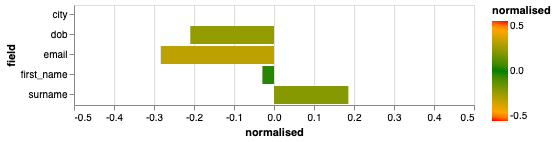

In [178]:
import altair as alt 
chart_data = alt.Data(values=adjustment_factors)
chart = alt.Chart(chart_data).mark_bar().encode(
        x=alt.X('normalised:Q', scale=alt.Scale(domain=[-0.5,0.5])),
        y=alt.Y('field:N'),
        color = alt.Color('normalised:Q', scale=alt.Scale(domain=[-0.5, -0.4, 0, 0.4, 0.5], range=['red', 'orange', 'green', 'orange', 'red'])),
        tooltip = ['field:N', 'normalised:Q']
)
chart


ZeroDivisionError: float division by zero

In [42]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
dfpd.sample(10)[["match_probability"] + list(dfpd.columns)]

,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability
1161,0.812300,473,474,Henry,Henry,Ali,Ali,2012-11-30,2013-02-12,Newcastle-upon-Tyne,Newcaetle-upo-Tyns,None,laura1o@nelon.c2m,2,2,0,0,-1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.5074800252914429,0.20798799395561218,0.13366299867630005,0.1701200008392334,1.00000000000000000,1.00000000000000000,0.812300
767,0.975794,69,72,Isabella,Isabella,Coepo,Cooper,1987-11-18,1987-11-18,Stockton-Tn-oee,Stockton-on-Tees,imoore@turner-gonzalez.info,imoore@turner-gonzalez.info,2,0,1,0,1,0.747147023677825900,0.66516697406768800,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.975794
892,0.765192,792,796,Aisha,King,King,Aisha,1980-04-24,1980-04-24,Telford,Telford,None,berrylarry@gonzales.biz,0,0,1,1,-1,0.247991994023323060,0.27030000090599060,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,1.00000000000000000,1.00000000000000000,0.765192
863,0.999541,539,541,Fredie,Freddie,Roberts,Roberts,2004-11-15,2004-11-15,Bolton,Bolton,browndonald@mccormick.info,browndonald@mccormick.info,1,2,1,1,1,0.004861999768763781,0.06453300267457962,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.999541
486,0.994877,669,672,Ivy,Ivy,Taylor,Taylor,1980-01-13,1980-01-13,Lodno,noLdo,jonesjennifer@pitts.com,jonesjennifer@pitts.com,2,2,1,0,1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.994877
1535,0.971517,714,715,Hughes,None,Arthur,Hughes,1998-08-24,1998-08-24,Sheffield,Sheffield,eileenlopez@mcmahon-long.info,eileenlopez@mcmahon-long.info,-1,0,1,1,1,1.000000000000000000,1.00000000000000000,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.971517
241,0.993185,363,364,Nancy,Nancy,Taylor,Taylor,1989-07-25,1989-07-25,London,London,wagnershane@landry.com,wagnershane@landry.com,2,2,1,1,1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.993185
978,0.930264,942,944,Oscar,Oscar,James,James,1985-03-26,1985-03-26,Yro,None,None,carlos74@byrd.com,2,2,1,-1,-1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,1.00000000000000000,1.0000000000000000,1.00000000000000000,1.00000000000000000,0.930264
1049,1.000000,71,78,Isabella,Isabell,Cooper,Coopr,1987-11-18,1987-11-18,Stockton-on-Tees,Stockton-on-Tees,imoore@turner-gonzalez.info,imoore@turner-gonzalez.info,1,1,1,1,1,0.004861999768763781,0.06453300267457962,0.0173530001193285,0.07856699824333191,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,1.000000
180,0.877502,384,386,Lewis,Abigail,Abigail,None,2017-02-05,2017-02-05,Reading,Reading,None,james08@hernandez.info,0,-1,1,1,-1,0.247991994023323060,0.27030000090599060,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,1.00000000000000000,1.00000000000000000,0.877502


In [45]:
from sparklink.term_frequencies import make_adjustment_for_term_frequencies
df_e_adj = make_adjustment_for_term_frequencies(df_e, params, ["first_name", "surname"], retain_adjustment_columns=True, spark=spark)

In [49]:
pdtf = df_e_adj.toPandas()
pdtf.sample(10)[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

,match_probability,tf_adjusted_match_prob,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability,first_name_adj,surname_adj,tf_adjusted_match_prob
923,0.986838,0.986836,978,985,None,None,Ball,None,1992-04-02,1992-04-02,Newcastle-upon-Tyne,Newcastle-upon-Tyne,stacykelly@brown.info,stacykelly@brown.info,-1,-1,1,1,1,1.000000000000000000,1.00000000000000000,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.986838,0.500000,0.500000,0.986836
1272,0.988843,0.999561,967,968,Isla,Isla,None,Beattie,2008-05-07,2008-05-07,Bolton,Btlon,susanmoreno@edwards-wallace.com,susanmoreno@edwards-wallace.com,2,-1,1,0,1,0.747147023677825900,0.66516697406768800,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.988843,0.962548,0.500000,0.999561
714,0.975794,0.968941,306,310,Isabelle,Isabelle,Born,Brown,1979-01-22,1979-01-22,Stte-on-Trenk,Stoke-on-Trent,josephwatson@smith.com,josephwatson@smith.com,2,0,1,0,1,0.747147023677825900,0.66516697406768800,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.975794,0.436267,0.500000,0.968941
1406,0.973814,0.973812,950,953,Ameia,Johnson,Johnson,Amelia,1985-05-04,1985-05-04,Luton,Luton,olsondanielle@martinez.com,olsondanielle@martinez.com,0,0,1,1,1,0.247991994023323060,0.27030000090599060,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.973814,0.500000,0.500000,0.973812
1387,0.973778,0.983035,817,820,George,George,Hill,Hill,1984-05-07,1984-03-16,Northampton,Northampton,smithmelinda@christensen-harvey.com,smithmelinda@christensen-harvey.com,2,2,0,1,1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.5074800252914429,0.20798799395561218,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.973778,0.446187,0.659505,0.983035
142,0.474468,0.474468,523,526,Brown,Martha,Martha,Brown,2002-09-01,2002-09-01,Southend-on-Sea,Southend-on-Sea,watsonthomas@jones-stuart.biz,watsonthomas@jones-s.urttbiz,0,0,1,1,0,0.247991994023323060,0.27030000090599060,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.93505102396011350,0.25905999541282654,0.474468,0.500000,0.500000,0.474468
1093,0.726907,0.625929,804,809,Darcy,Darcy,Webtsr,Webster,1984-02-07,1984-02-07,Colchester,Colchester,katherine96@kim-martinez.com,None,2,0,1,1,-1,0.747147023677825900,0.66516697406768800,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,1.00000000000000000,1.00000000000000000,0.726907,0.385992,0.500000,0.625929
1683,0.960302,0.960300,291,295,Arlo,Arl,Morgan,None,2015-05-15,2015-05-15,Aberdeen,Aberdeen,charles81@elion.bsz,charles81@nelson.biz,1,-1,1,1,0,0.004861999768763781,0.06453300267457962,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.93505102396011350,0.25905999541282654,0.960302,0.500000,0.500000,0.960300
676,0.944481,0.939050,229,236,Charlotte,Charlotte,None,Coper,1995-06-15,1995-06-17,Sunderland,Sunderland,toddsean@wilkins-burton.biz,toddsean@wilkins-burton.biz,2,-1,0,1,1,0.747147023677825900,0.66516697406768800,1.0000000000000000,1.00000000000000000,0.5074800252914429,0.20798799395561218,0.86633700132370000,0.8298799991607666,0.064948998391628

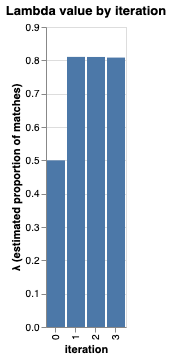

In [29]:
params.lambda_iteration_chart()

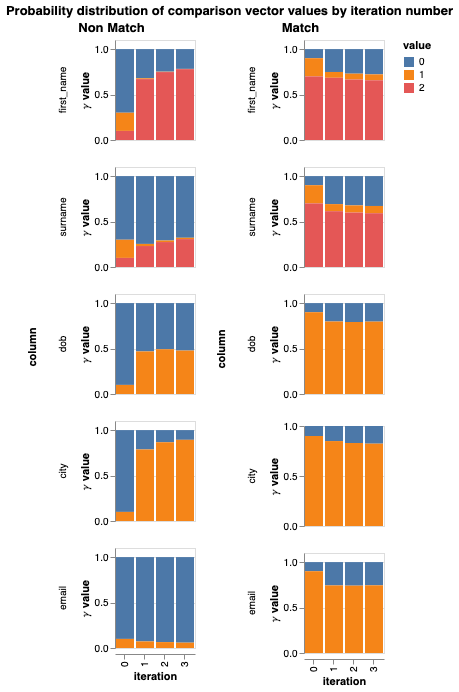

In [30]:
params.pi_iteration_chart()